# Topic Modelling with Gensim and Scikit Learn

Date: 4 February 2020

I downloaded some of the Jan 2020 and Dec 2019 Singapore newspaper articles from the web and extracted the text from the PDFs.   
I will attempt to perform Topic Modelling with two different packages (Gensim and Scikit-Learn) and make a comparison.

## Import Libraries

In [4]:
import numpy as np
import pandas as pd
import pickle
import os
import re

# Gensim
import gensim
from gensim import corpora
from gensim.utils import simple_preprocess

# NLTK
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk import PorterStemmer
from nltk.corpus import stopwords
stop_words = stopwords.words("english")
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

# Spacy
import spacy
from spacy.lang.en import English

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Read PDFs
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
from io import StringIO

# Visualization
import pyLDAvis.gensim
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from collections import Counter
from matplotlib.patches import Rectangle
from matplotlib.ticker import FuncFormatter
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

%matplotlib inline

# Wordcloud
from wordcloud import WordCloud, STOPWORDS

## Settings

In [7]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

## Scanning PDFs Articles

In [ ]:
# obtain all pdfs name
pdfs = []
for file in os.listdir("."):
    if file.endswith(".pdf"):
        pdfs.append(file)

In [ ]:
def convert_pdf_to_text(path):
    rsrcmgr = PDFResourceManager()
    retstr = StringIO()
    codec = "utf-8"
    laparams = LAParams()
    device = TextConverter(rsrcmgr, retstr, laparams=laparams)
    fp = open(path, "rb")
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    password = ""
    maxpages = 0
    caching = True
    pagenos = set()
    
    for page in PDFPage.get_pages(fp, pagenos, maxpages=maxpages, password=password, caching=caching,
                                  check_extractable=True):
        interpreter.process_page(page)
        
    text = retstr.getvalue()
    
    fp.close()
    device.close()
    retstr.close()
    return text

In [ ]:
text = []
for i in pdfs:
    text.append(convert_pdf_to_text(i))

In [ ]:
text_data = pd.DataFrame(text)
text_data.columns = ["Text"]
text_data["Text"] = text_data["Text"].apply(lambda x: " ".join(x.split()))
# remove all words in a bracket
regex = re.compile("[\(\[].*?[)\]]")
text_data["Text"] = text_data["Text"].apply(lambda x: re.sub(regex, "", x))

## Import Data

In [8]:
text_data_2020 = pd.read_csv("text_data_2020.csv")

In [9]:
text_data_2019 = pd.read_csv("text_data_2019.csv")

In [10]:
text_data = pd.concat([text_data_2020, text_data_2019],axis=0)

In [11]:
text_data = text_data.reset_index().drop("index",axis=1)

## Data Preprocessing

In [12]:
text_data_raw = text_data.copy()

In [13]:
text_data_raw["Text"] = text_data_raw["Text"].astype(str)

In [14]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('- ', "", sent)
        sent = " ".join(sent.split())
        sent = re.sub("\'", "", sent) # remove single quotes
        sent = re.sub("_", " ", sent)
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) #deacc=T removes puncutuations
        yield(sent)

In [15]:
# convert to list
data = text_data_raw["Text"].tolist()
data_words = list(sent_to_words(data))

In [16]:
def cut_words(text):
    placeholder = []
    for i in range(0, len(data_words)):
        clean_text = [token for token in data_words[i] if len(token) >4]
        placeholder.append(clean_text)
    return placeholder

In [17]:
text_data_raw["tokenize"] = cut_words(data_words)

In [18]:
# removes empty cell
to_remove = []
for i in range(0, len(text_data_raw)):
    if (len(text_data_raw["tokenize"][i]) == 0):
        to_remove.append(i)

In [19]:
text_data_raw = text_data_raw.drop(to_remove)

In [20]:
text_data_raw = text_data_raw.drop([15, 21])

In [21]:
text_data_raw = text_data_raw.reset_index().drop("index",axis=1)

### Building Bigram, Trigram Models and Lemmatize

In [22]:
bigram = gensim.models.Phrases(text_data_raw["tokenize"], min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[text_data_raw["tokenize"]], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [23]:
def process_words(texts, stop_words=stop_words, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    # removes stopwords from bigrams, trigrams and lemmatization
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=["parser", "ner"])
    
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # removes stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]
    return texts_out

In [24]:
data_ready = process_words(text_data_raw["tokenize"])

In [25]:
text_data_raw["clean"] = data_ready

## 1. Building Topic Model with Gensim

In [26]:
# create dictionary
id2word = corpora.Dictionary(data_ready)

In [27]:
# create corpus: Term Document Frequency (Bag of words)
corpus = [id2word.doc2bow(text) for text in data_ready]

In [28]:
# build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word = id2word,
                                            num_topics=4,
                                            random_state=100,
                                            update_every=1,
                                            chunksize=20,
                                            passes=10,
                                            alpha="symmetric", #auto, assymmetric
                                            iterations=100,
                                            per_word_topics=True)

In [29]:
lda_model.print_topics()

[(0,
  '0.017*"reserve" + 0.012*"tunnel" + 0.012*"singapore" + 0.010*"transport" + 0.010*"nature" + 0.009*"station" + 0.008*"cross_island" + 0.007*"impact" + 0.007*"work" + 0.007*"nature_reserve"'),
 (1,
  '0.024*"singapore" + 0.011*"business" + 0.009*"singaporean" + 0.007*"global" + 0.007*"investment" + 0.007*"sector" + 0.007*"expect" + 0.007*"china" + 0.006*"growth" + 0.006*"employment"'),
 (2,
  '0.008*"council" + 0.007*"worker" + 0.007*"water" + 0.006*"owner" + 0.006*"excavator" + 0.005*"worksite" + 0.005*"incident" + 0.005*"yesterday" + 0.005*"area" + 0.005*"find"'),
 (3,
  '0.015*"singapore" + 0.010*"green" + 0.010*"company" + 0.009*"business" + 0.008*"building" + 0.006*"keppel" + 0.006*"digital" + 0.006*"technology" + 0.006*"industry" + 0.005*"system"')]

### Dominant Topic Identification

In [30]:
# Dominant Topic
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # init output
    sent_topics_df = pd.DataFrame()
    
    # get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        row = sorted(row, key=lambda x:(x[1]), reverse=True)
        # get dominant topic, % contribution and keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if (j == 0): # dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ",".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic, 4),
                                                                  topic_keywords]), ignore_index=True)
            else:
                break
    
    sent_topics_df.columns = ["Dominant_Topic", "Percentage_Contribution", "Topic_Keywords"]
    
    # add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [31]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ["Document_No", "Dominant_Topic", "Topic_Percentage_Contribution", "Keywords", "Text"]

### Most Representive Sentence for each Topic

In [32]:
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby("Dominant_Topic")

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, grp.sort_values(["Percentage_Contribution"],
                                                                                            ascending=False).head(1)], axis=0)
    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

In [33]:
# format
sent_topics_sorteddf_mallet.columns = ["Topic_Num", "Topic_Percentage_Contribution", "Keywords", 
                                       "Representative Text"]

#sent_topics_sorteddf_mallet.head(10)

### Frequency Distribution of Word Counts in Documents

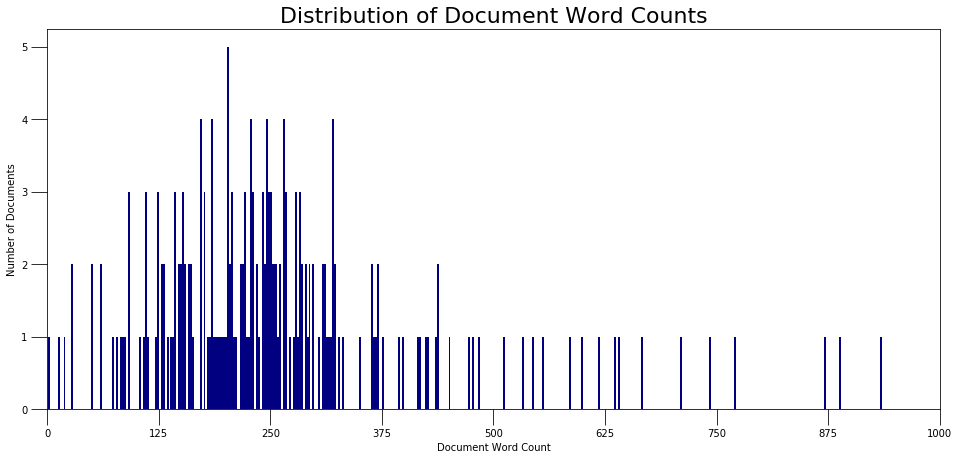

In [34]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# plot
plt.figure(figsize=(16,7)) #dpi=160)
plt.hist(doc_lens, bins=1000, color="navy")
#plt.text(750, 100, "Mean: " + str(round(np.mean(doc_lens))))
#plt.text(750, 90, "Median: "+ str(round(np.median(doc_lens))))
#plt.text(750, 80, "Stdev: " + str(round(np.std(doc_lens))))
#plt.text(750, 70, "1%ile: " +str(round(np.quantile(doc_lens, q=0.01))))
#plt.text(750, 60, "99%ile: " +str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0,1000), ylabel="Number of Documents", xlabel="Document Word Count")
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title("Distribution of Document Word Counts", fontdict=dict(size=22))
plt.show()

In [35]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

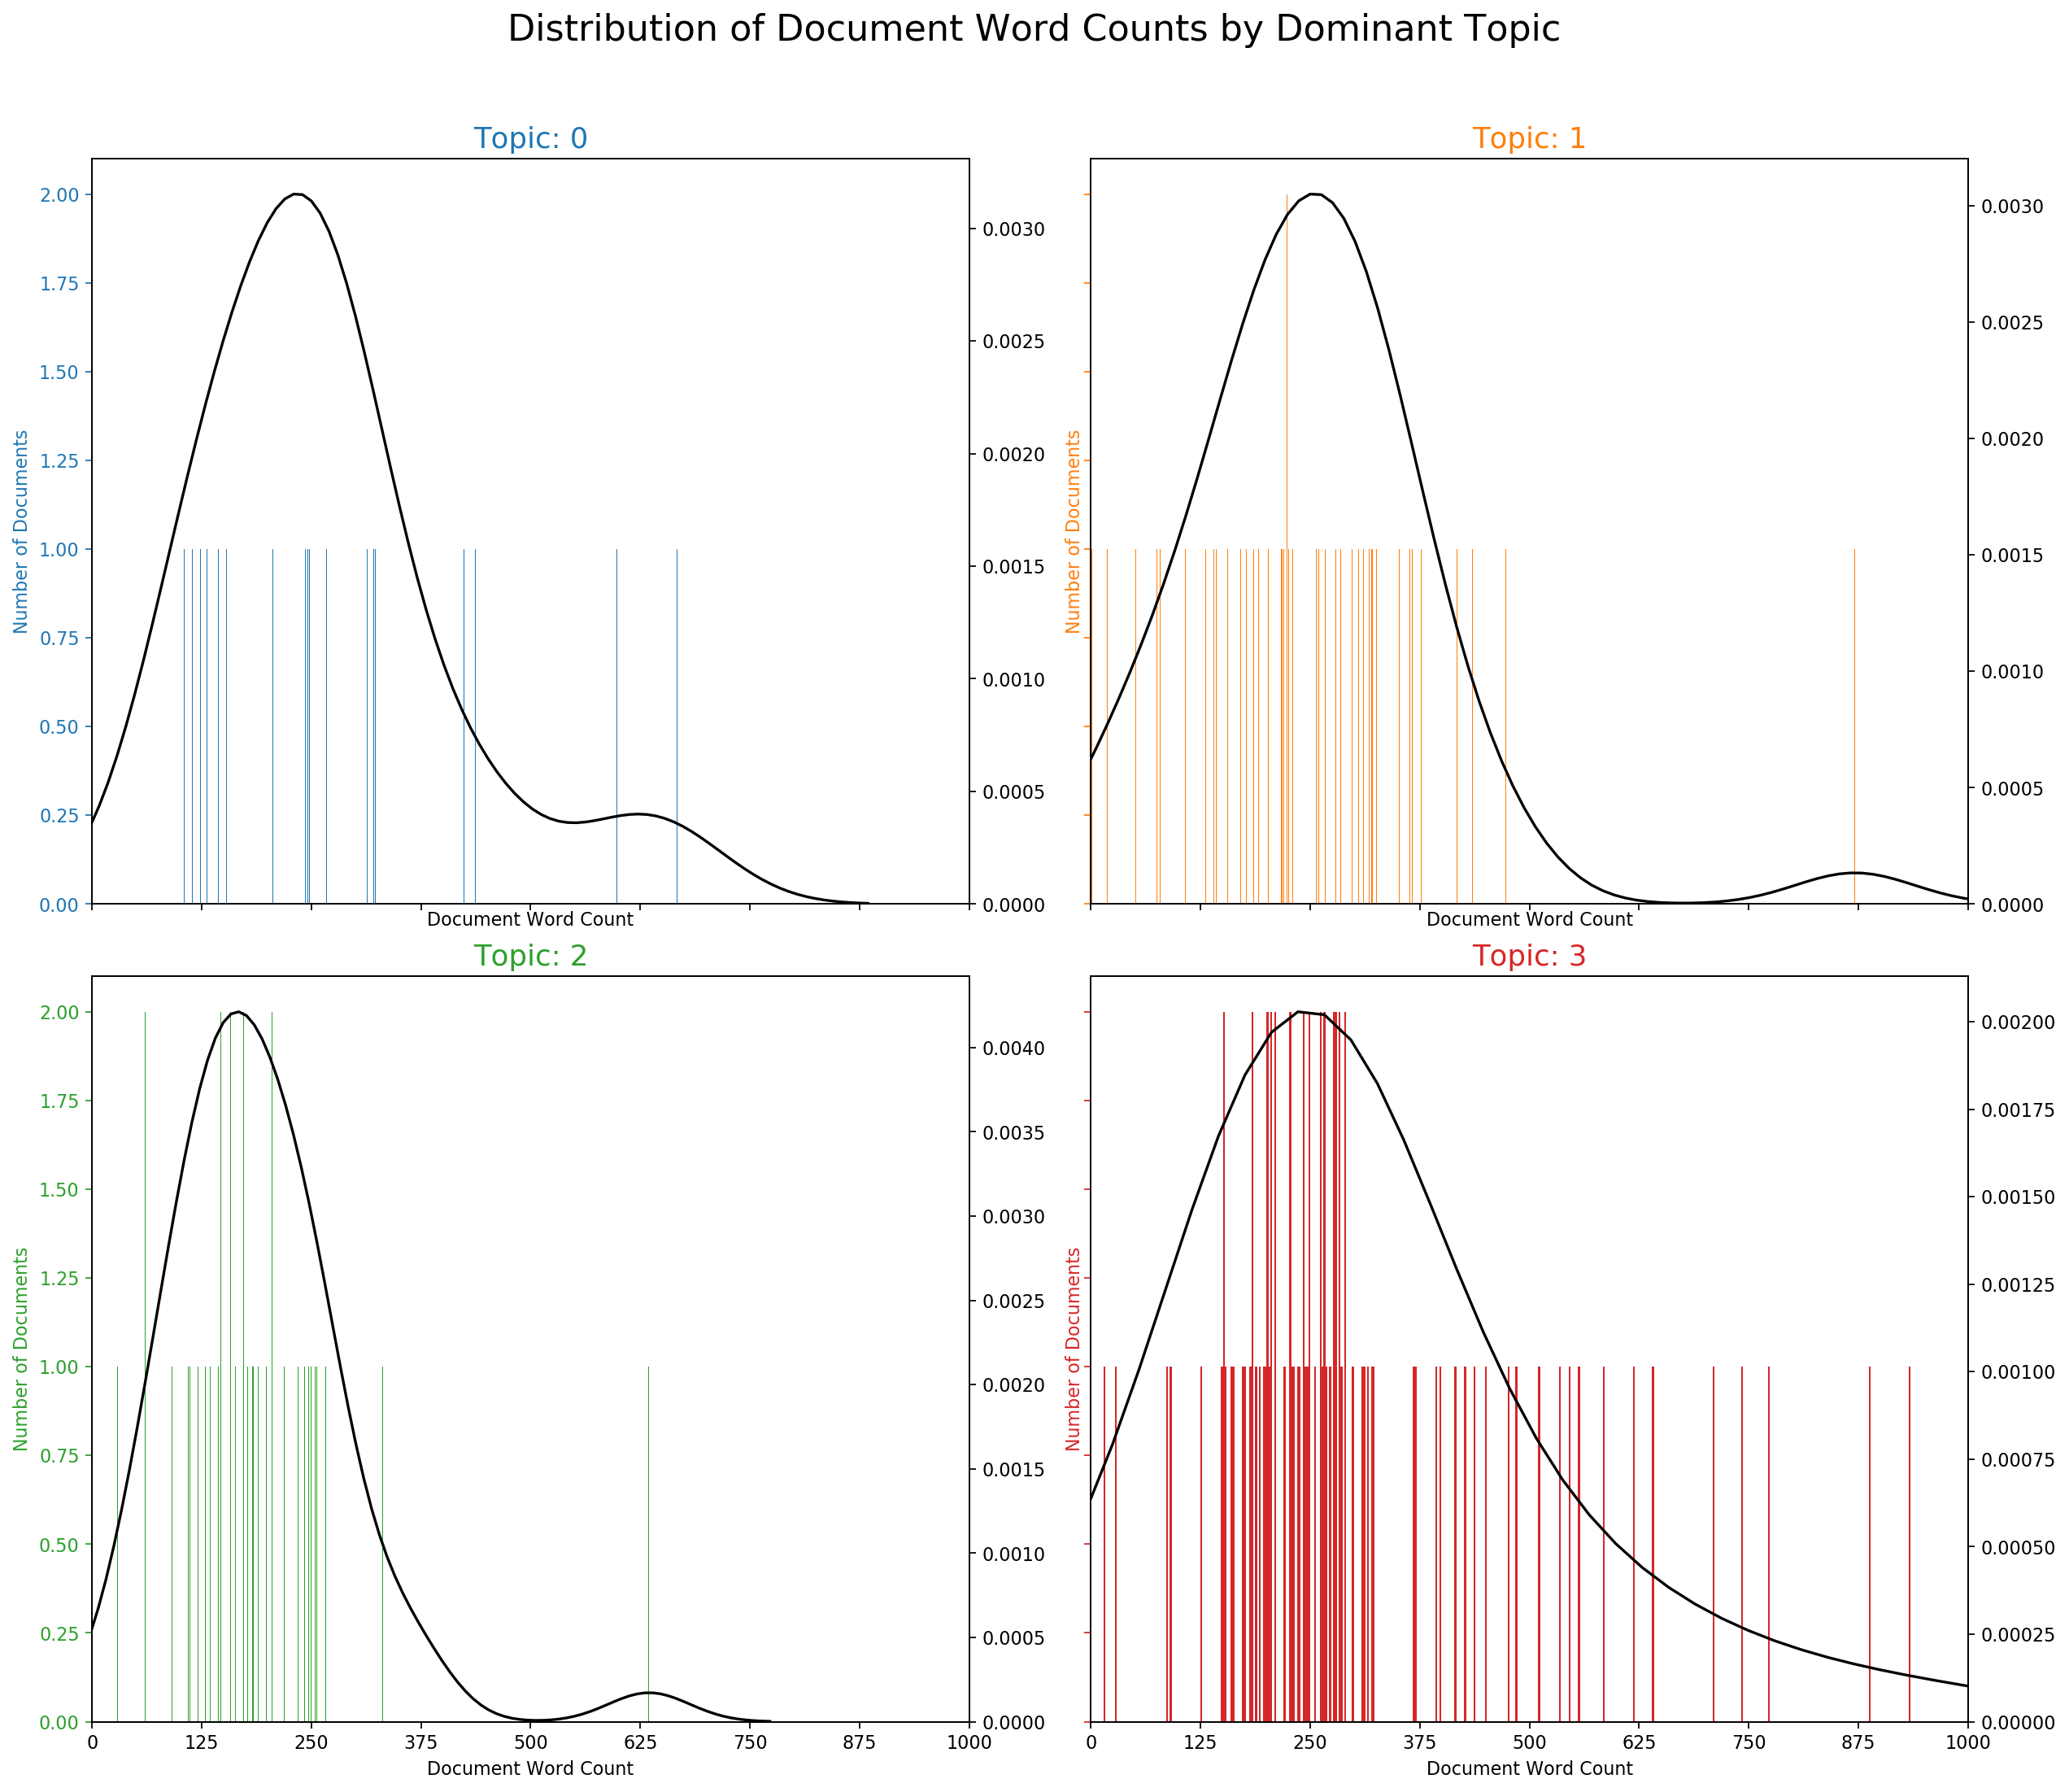

In [36]:
fig, axes = plt.subplots(2, 2, figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic==i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins=1000, color=cols[i])
    ax.tick_params(axis="y", labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0,1000), xlabel="Document Word Count")
    ax.set_ylabel("Number of Documents", color=cols[i])
    ax.set_title("Topic: "+str(i), fontdict=dict(size=16, color=cols[i]))
    
fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle("Distribution of Document Word Counts by Dominant Topic", fontsize=20)
plt.show()

### Word Clouds of Top N Keywords in Each Topic

In [37]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

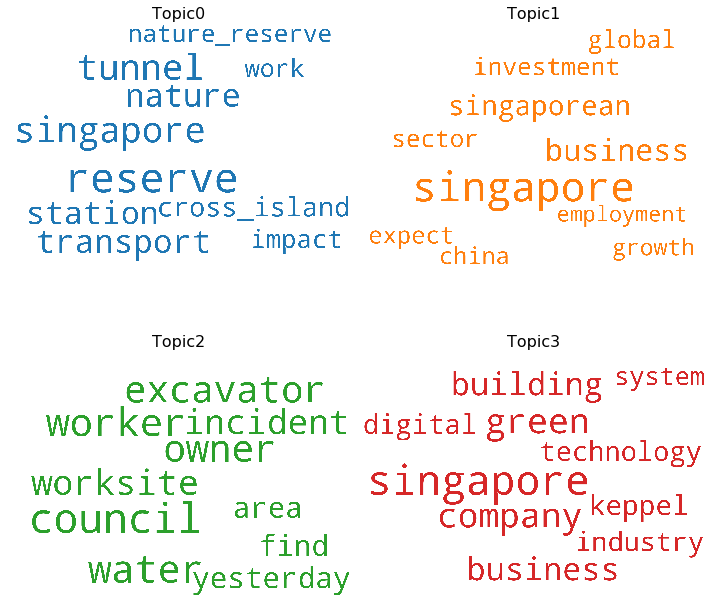

In [38]:
cloud = WordCloud(stopwords=stop_words,
                  background_color="white",
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap="tab10",
                  color_func=lambda*args, **kwargs:cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2,2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title("Topic" + str(i), fontdict=dict(size=16))
    plt.gca().axis("off")
    
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis("off")
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

We can further group the topics:   
Topic0: Transportation - I can infer that the Cross Island Line has something to do with nature reserve.    
Topic1: Economy - I can infer that Singpore is expecting growth and that investment and employment are indicators.       
Topic2: Incident - I can infer that there was an incident involving a worker and an excavator at the worksite.    
Topic3: Sustainability/Digitalisation - I can infer that Keppel is involved in some green building

### Word Counts of Topic Keywords

In [39]:
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

In [40]:
out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i, weight, counter[word]])

In [41]:
df = pd.DataFrame(out, columns=["word", "topic_id", "importance", "word_count"])

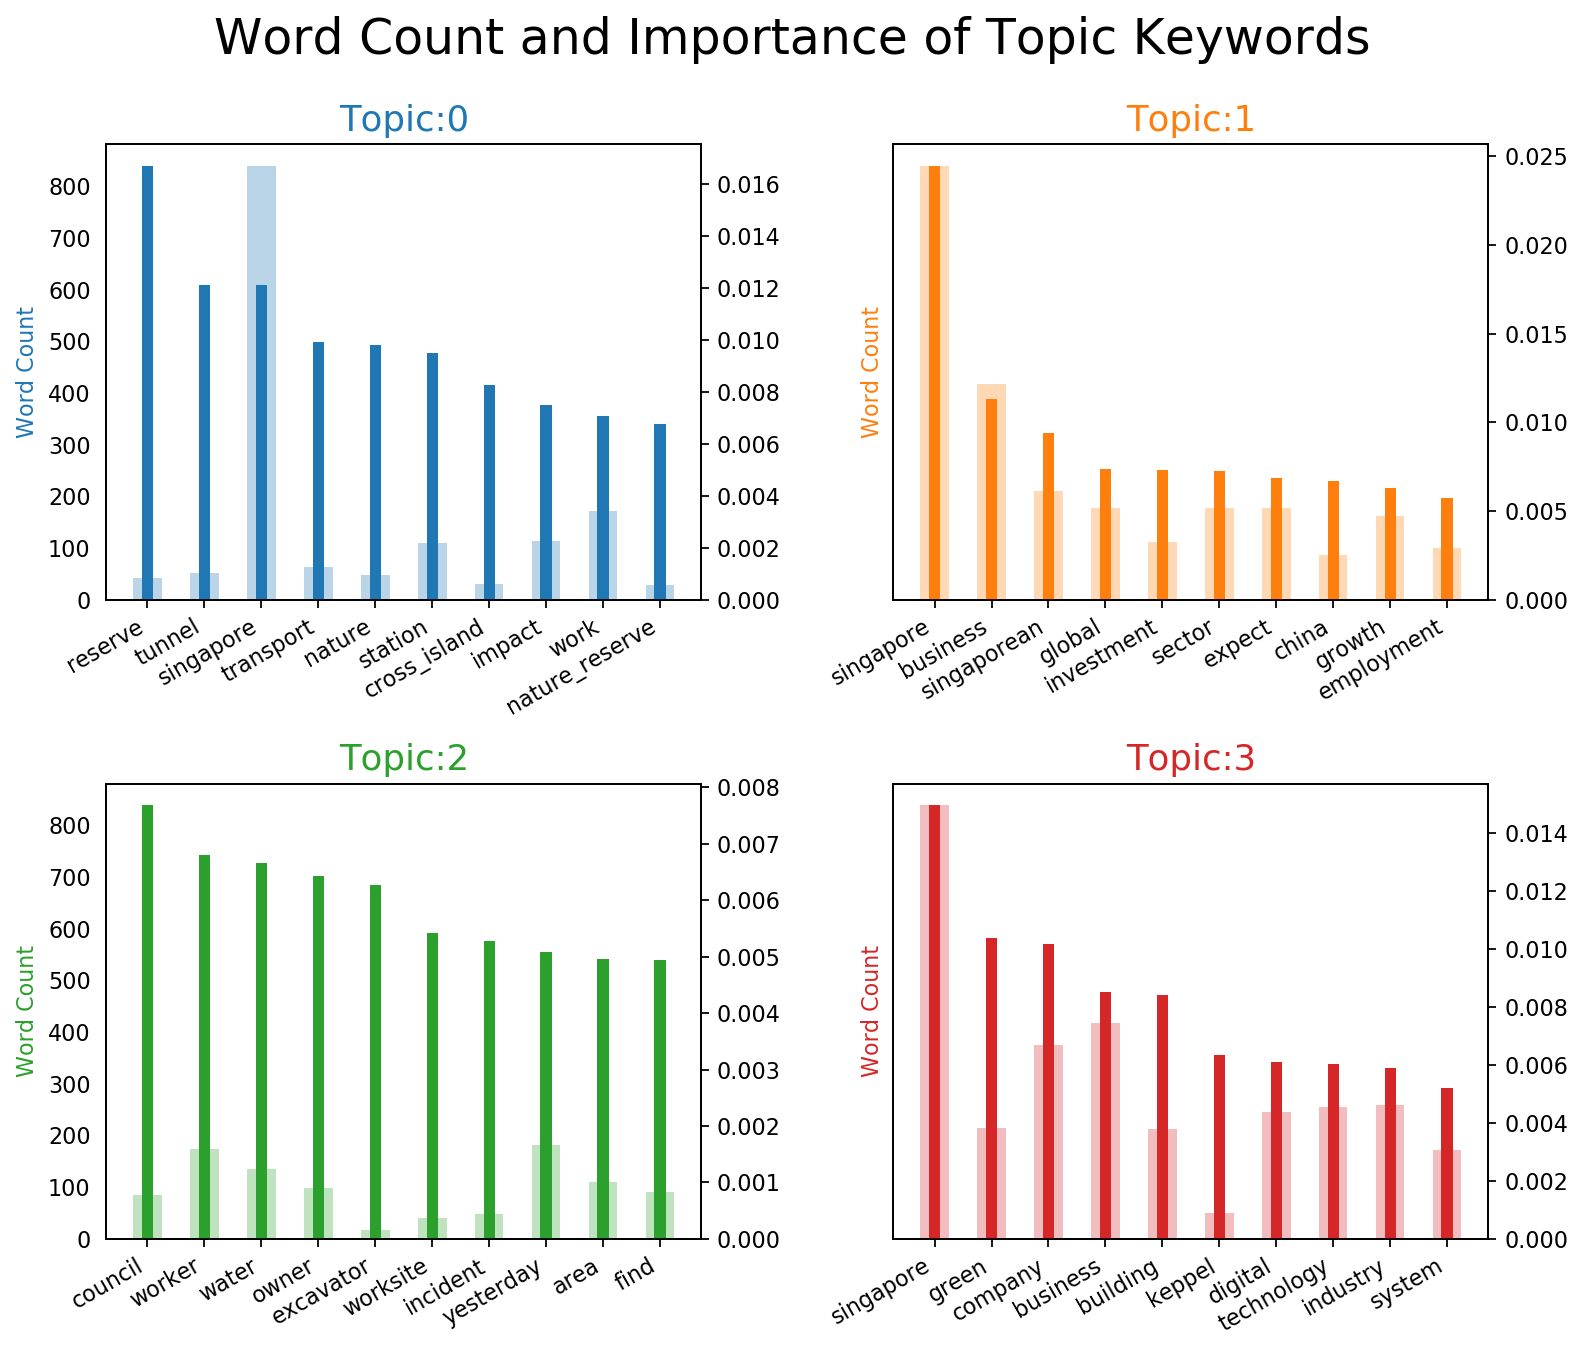

In [42]:
# plot word count and weights of topic keywords
fig, axes = plt.subplots(2,2, figsize=(10,8), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x="word", height="word_count", data=df.loc[df.topic_id==i, :],
           color=cols[i], width=0.5, alpha=0.3, label="Word Count")
    ax_twin = ax.twinx()
    ax_twin.bar(x="word", height="importance", data=df.loc[df.topic_id==i, :],
                color=cols[i], width=0.2, label="Weights")
    ax.set_ylabel("Word Count", color=cols[i])
    #ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title("Topic:" + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis="y", left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, "word"], rotation=30, horizontalalignment="right")
    #ax.legend(loc="upper left"); ax_twin.legend(loc="upper right")
    
fig.tight_layout(w_pad=2)
fig.suptitle("Word Count and Importance of Topic Keywords", fontsize=22, y=1.05)
plt.show()

### Sentence Chart Coloured by Topics

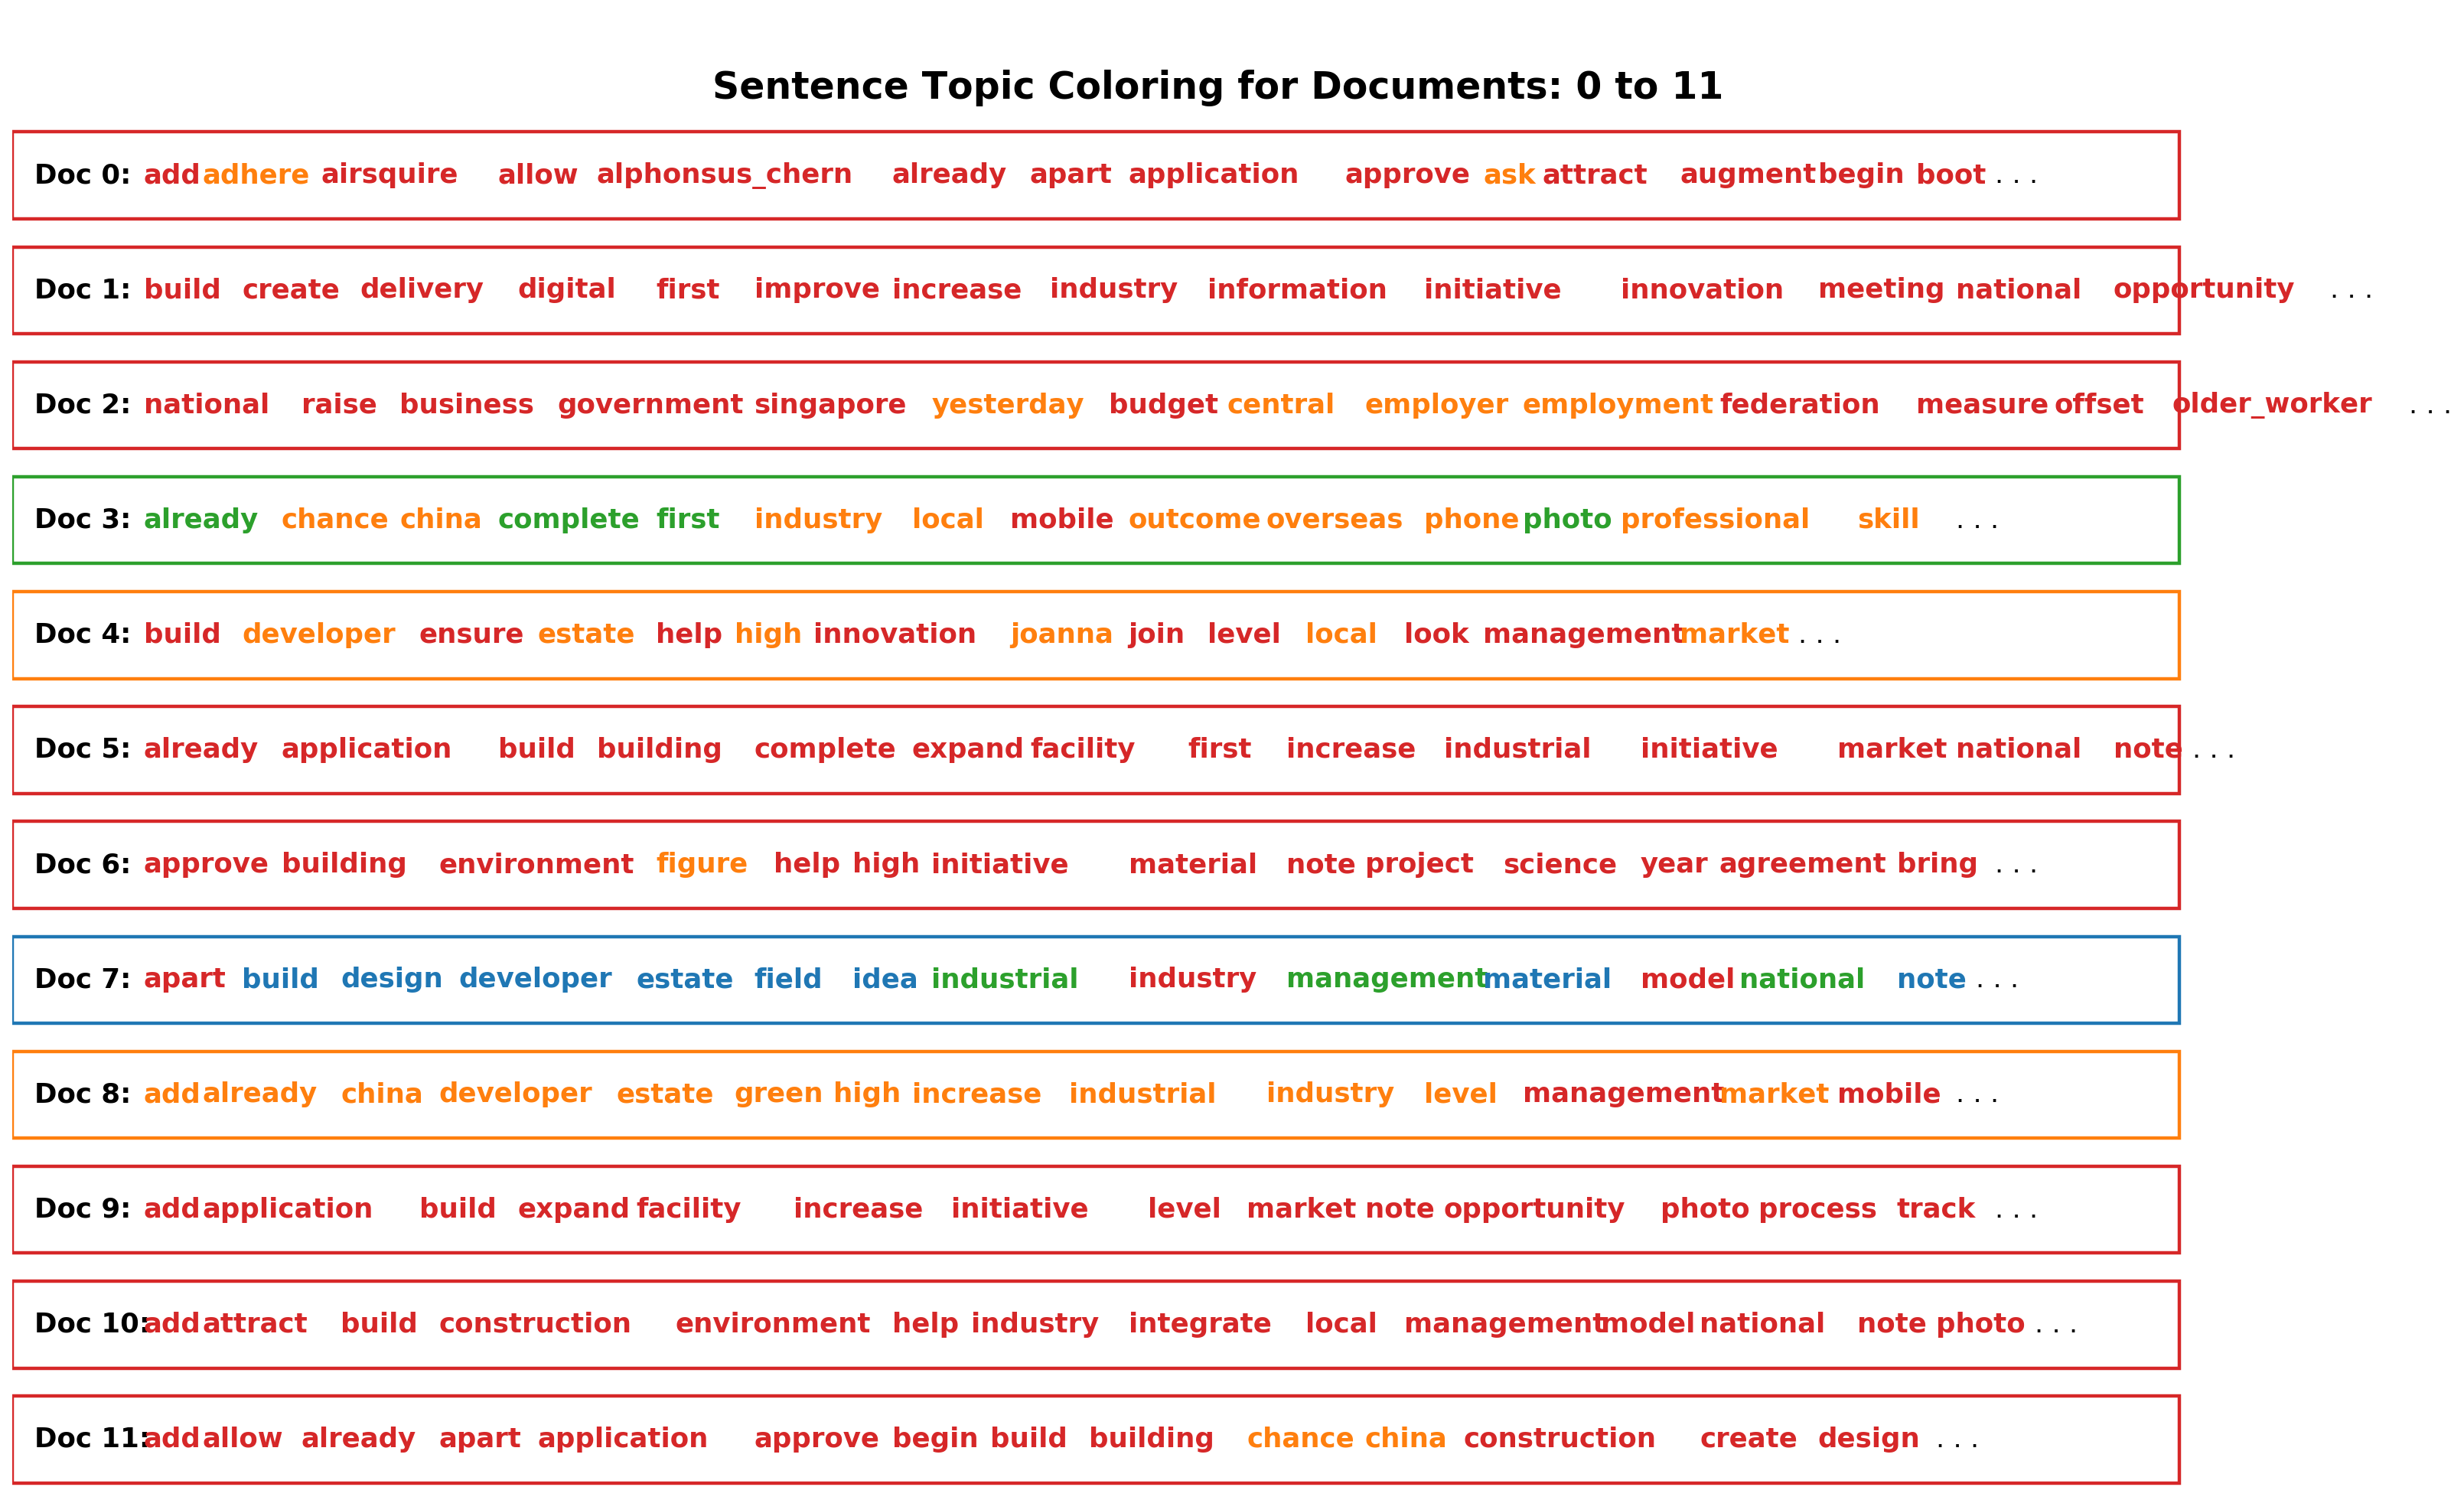

In [43]:
# Sentence Coloring of N Sentences

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    

### Most discussed topics in the documents

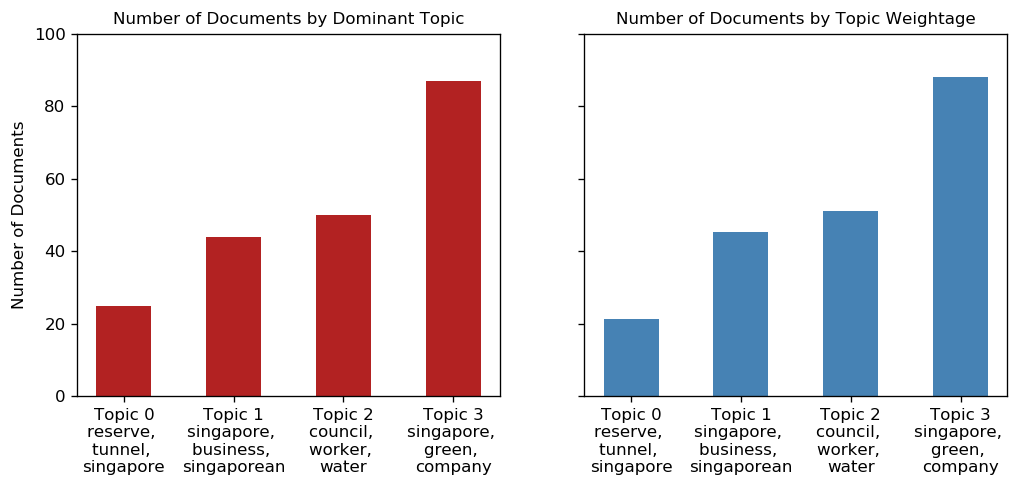

In [44]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 100)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

### t-SNE Clustering Chart

In [45]:
# get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])
    
# array of topic weights
arr = pd.DataFrame(topic_weights).fillna(0).values

# keep the well separated points 
arr = arr[np.max(arr, axis=1) > 0.35]

# dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=0.99, init="pca")
tsne_lda = tsne_model.fit_transform(arr)

# plot the topic clusters using bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics),
               plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 207 samples in 0.004s...
[t-SNE] Computed neighbors for 207 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 207 / 207
[t-SNE] Mean sigma: 0.148012
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.252018
[t-SNE] KL divergence after 1000 iterations: 0.181171


Loading BokehJS ...

### pyLDAVis

In [46]:
pyLDAvis.enable_notebook()

In [47]:
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.103176  0.030762       1        1  50.272022
1      0.157901  0.047637       2        1  21.527775
2     -0.069424 -0.210433       3        1  17.808023
0     -0.191654  0.132034       4        1  10.392179, topic_info=                Term        Freq       Total Category  logprob  loglift
4232         reserve  103.000000  103.000000  Default  30.0000  30.0000
286        singapore  868.000000  868.000000  Default  29.0000  29.0000
173         business  396.000000  396.000000  Default  28.0000  28.0000
465      singaporean  121.000000  121.000000  Default  27.0000  27.0000
5531          tunnel   75.000000   75.000000  Default  26.0000  26.0000
1853       transport   90.000000   90.000000  Default  25.0000  25.0000
248           nature   72.000000   72.000000  Default  24.0000  24.0000
361          council   86.000000   86.000000  Default  23.0000  23.0000
977          station   58.000000   58.000000  Default  22.0000  22.0000
231       investment  127.000000  127.000000  Default  21.0000  21.0000
220           global  145.000000  145.000000  Default  20.0000  20.0000
20             china   86.000000   86.000000  Default  19.0000  19.0000
774           impact   98.000000   98.000000  Default  18.0000  18.0000
583           sector  162.000000  162.000000  Default  17.0000  17.0000
687           reduce  171.000000  171.000000  Default  16.0000  16.0000
657           keppel  189.000000  189.000000  Default  15.0000  15.0000
724            water  113.000000  113.000000  Default  14.0000  14.0000
15             build  192.000000  192.000000  Default  13.0000  13.0000
1208    cross_island   51.000000   51.000000  Default  12.0000  12.0000
37           digital  181.000000  181.000000  Default  11.0000  11.0000
6056       excavator   66.000000   66.000000  Default  10.0000  10.0000
197      development  221.000000  221.000000  Default   9.0000   9.0000
315       employment   73.000000   73.000000  Default   8.0000   8.0000
223           growth  127.000000  127.000000  Default   7.0000   7.0000
632           expect  184.000000  184.000000  Default   6.0000   6.0000
151             work  144.000000  144.000000  Default   5.0000   5.0000
943          quarter   87.000000   87.000000  Default   4.0000   4.0000
2431          survey   69.000000   69.000000  Default   3.0000   3.0000
900           future  113.000000  113.000000  Default   2.0000   2.0000
16          building  283.000000  283.000000  Default   1.0000   1.0000
657           keppel  188.470551  189.149994   Topic1  -5.0590   0.6841
37           digital  180.938751  181.627502   Topic1  -5.0998   0.6839
522           energy  151.800491  152.497894   Topic1  -5.2754   0.6831
1804        solution  119.164330  119.853004   Topic1  -5.5175   0.6820
658     keppel_tower  112.715462  113.394722   Topic1  -5.5731   0.6817
714   sustainability   95.151520   95.854156   Topic1  -5.7425   0.6804
1779        security   96.823151   97.542183   Topic1  -5.7251   0.6803
70        initiative   89.538574   90.231506   Topic1  -5.8033   0.6800
613   climate_change   91.007393   91.712975   Topic1  -5.7870   0.6800
105          process   81.287537   82.041588   Topic1  -5.9000   0.6785
71        innovation   73.762352   74.450806   Topic1  -5.9971   0.6784
64           improve  102.283150  103.426170   Topic1  -5.6702   0.6766
304   transformation   56.816624   57.517185   Topic1  -6.2581   0.6755
1801           smart   54.954556   55.644630   Topic1  -6.2915   0.6752
515         customer   53.510193   54.199352   Topic1  -6.3181   0.6749
155          achieve   57.918793   58.684132   Topic1  -6.2389   0.6746
2699           grant   54.224159   54.944874   Topic1  -6.3049   0.6745
1102        platform   52.201035   52.933304   Topic1  -6.3429   0.6738
222            great   50.035770   50.743629   Topic1  -6.3852   0.6737
703            solar   48.229095 

## 2. Building Topic Model with Scikit Learn

In [48]:
def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

In [49]:
nlp = spacy.load("en", disable=["parser", "ner"])

In [50]:
data_lemmatized = lemmatization(data_ready, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

### Create Document-Word Matrix

In [51]:
# Bag of words
vectorizer = CountVectorizer(analyzer = "word",
                             min_df=5, # minimum required occurence of words
                             stop_words="english", # remove stopwords
                             lowercase=True, # convert all words to lowercase
                             token_pattern = '[a-zA-Z0-9]{3,}', # num chars >3
                             max_features = 50000) # max number of unique words
                             
data_vectorized = vectorizer.fit_transform(data_lemmatized)

### Check Sparsicity

In [52]:
data_dense = data_vectorized.todense()
print("Sparsicity: ", ((data_dense>0).sum()/data_dense.size)*100, "%")

Sparsicity:  7.320698625046451 %


### Build LDA Model

In [53]:
lda_model = LatentDirichletAllocation(n_components=4,
                                      max_iter=10, # max learning iterations
                                      learning_method="online",
                                      random_state=100,
                                      batch_size=10, # n docs in each learning iter
                                      evaluate_every=-1,
                                      n_jobs=-1)

In [54]:
lda_output = lda_model.fit_transform(data_vectorized)

In [55]:
print(lda_model)

LatentDirichletAllocation(batch_size=10, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=4, n_jobs=-1,
                          perp_tol=0.1, random_state=100, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)


### Diagnose model performance with perplexity and log-likelihood

Good Model: Higher log-likelihood and lower perplexity   
Note: Perplexity does not consider context and the semantic associations between words hence might not be a good measure. This can be captured using topic coherence measure.

In [56]:
# log-likelihood
print("Log Likelihood:", lda_model.score(data_vectorized))

# perplexity
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# see model parameters
pprint(lda_model.get_params())

Log Likelihood: -318695.79990167794
Perplexity:  943.3161124468328
{'batch_size': 10,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 4,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


### GridSearch

In [57]:
# define search pattern
search_params = {"n_components":[4,8,12],
                 "learning_decay":[0.5, 0.7, 0.9]}

# initiate the model
lda = LatentDirichletAllocation()

# initiate grid search class
model = GridSearchCV(lda, param_grid=search_params)

# fit search
model.fit(data_vectorized)

C:\Users\joann\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                   

In [58]:
# best model
best_lda_model = model.best_estimator_

# best parameters
print("Best Model's Params: ", model.best_params_)

# log likelihood score
print("Best Log Likelihood Score: ", model.best_score_)

# perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 4}
Best Log Likelihood Score:  -115259.60789634273
Model Perplexity:  927.5893977109419


### Comparing LDA Model Performance Scores

In [59]:
# get log likelihoods from grid search output
n_topics = [4, 8, 12]
log_likelyhoods_5 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.5]
log_likelyhoods_7 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.7]
log_likelyhoods_9 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.9]

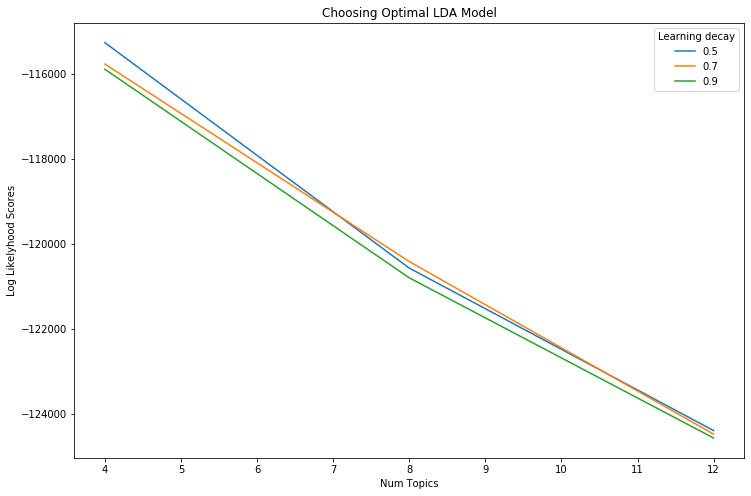

In [60]:
# show graph
plt.figure(figsize=(12,8))
plt.plot(n_topics, log_likelyhoods_5, label="0.5")
plt.plot(n_topics, log_likelyhoods_7, label="0.7")
plt.plot(n_topics, log_likelyhoods_9, label="0.9")
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title="Learning decay", loc="best")
plt.show()

### See Dominant Topic in each document

We want to see which topic has the highest contribution to that document and assign it

In [61]:
lda_output.shape

(207, 4)

In [62]:
# create document - topic matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]
#topicnames = ["Topic" + str(i) for i in range(lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data_ready))]

# make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output,2), 
                                 columns=topicnames,
                                 index=docnames)

# get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic["dominant_topic"] = dominant_topic

# styling
def color_green(val):
    color="green" if val >0.1 else "black"
    return "color: {col}".format(col=color)

def make_bold(val):
    weight=700 if val> 0.1 else 400
    return "font-weight: {weight}".format(weight=weight)

# apply style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,dominant_topic
Doc0,0.000000,0.200000,0.630000,0.160000,2
Doc1,0.000000,0.050000,0.950000,0.000000,2
Doc2,0.010000,0.010000,0.010000,0.970000,3
Doc3,0.200000,0.210000,0.310000,0.280000,2
Doc4,0.000000,0.130000,0.700000,0.170000,2
Doc5,0.370000,0.000000,0.560000,0.070000,2
Doc6,0.090000,0.000000,0.910000,0.000000,2
Doc7,0.800000,0.200000,0.000000,0.000000,0
Doc8,0.010000,0.000000,0.370000,0.620000,3
Doc9,0.060000,0.000000,0.940000,0.000000,2


### Review Topics Distribution across Documents

In [63]:
df_topic_distribution = df_document_topic["dominant_topic"].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ["Topic Num", "Num Documents"]
df_topic_distribution

,Topic Num,Num Documents
0,2,71
1,1,63
2,3,48
3,0,25


### pyLDAvis

In [64]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds="tsne")
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
0     -324.249390 -289.197083       1        1  36.406938
3     -200.549118 -570.859375       2        1  33.694263
1      -42.603127 -165.460297       3        1  15.565623
2       81.096878 -447.122253       4        1  14.333175, topic_info=                Term        Freq       Total Category  logprob  loglift
1671           water  128.000000  128.000000  Default  30.0000  30.0000
435          digital  234.000000  234.000000  Default  29.0000  29.0000
1406     singaporean  194.000000  194.000000  Default  28.0000  28.0000
1465         station   97.000000   97.000000  Default  27.0000  27.0000
990           nature  103.000000  103.000000  Default  26.0000  26.0000
186         business  408.000000  408.000000  Default  25.0000  25.0000
1295         reserve   84.000000   84.000000  Default  24.0000  24.0000
546           estate  123.000000  123.000000  Default  23.0000  23.0000
330     construction  220.000000  220.000000  Default  22.0000  22.0000
359          council   87.000000   87.000000  Default  21.0000  21.0000
1693          worker  207.000000  207.000000  Default  20.0000  20.0000
1211         quarter   70.000000   70.000000  Default  19.0000  19.0000
1200          public  170.000000  170.000000  Default  18.0000  18.0000
253          climate  138.000000  138.000000  Default  17.0000  17.0000
1181         project  219.000000  219.000000  Default  16.0000  16.0000
181            build  234.000000  234.000000  Default  15.0000  15.0000
825           island   77.000000   77.000000  Default  14.0000  14.0000
1188        property  101.000000  101.000000  Default  13.0000  13.0000
428      development  221.000000  221.000000  Default  12.0000  12.0000
1015         officer   82.000000   82.000000  Default  11.0000  11.0000
1538      technology  244.000000  244.000000  Default  10.0000  10.0000
1669           waste   92.000000   92.000000  Default   9.0000   9.0000
841           keppel  107.000000  107.000000  Default   8.0000   8.0000
1052           owner   96.000000   96.000000  Default   7.0000   7.0000
1297        resident   95.000000   95.000000  Default   6.0000   6.0000
889            local  121.000000  121.000000  Default   5.0000   5.0000
742          housing   69.000000   69.000000  Default   4.0000   4.0000
1574           trade  182.000000  182.000000  Default   3.0000   3.0000
750           impact  112.000000  112.000000  Default   2.0000   2.0000
223           change  227.000000  227.000000  Default   1.0000   1.0000
1406     singaporean  193.707073  194.831537   Topic1  -4.4711   1.0046
737            hotel   59.306887   60.155979   Topic1  -5.6547   0.9962
642        foreigner   44.949494   45.674718   Topic1  -5.9319   0.9944
914         manpower   46.695617   47.578991   Topic1  -5.8938   0.9917
342         contract   38.543957   39.439655   Topic1  -6.0856   0.9874
200           career   37.630952   38.652699   Topic1  -6.1096   0.9836
1173    professional   32.904807   33.859178   Topic1  -6.2438   0.9818
180           budget   29.456715   30.326172   Topic1  -6.3545   0.9813
889            local  118.008623  121.764859   Topic1  -4.9667   0.9791
1213        question   22.842054   23.664641   Topic1  -6.6088   0.9750
1444           spend   20.916195   21.676995   Topic1  -6.6969   0.9747
920           marina   20.444818   21.192849   Topic1  -6.7197   0.9745
17           acquire   19.135741   19.936545   Topic1  -6.7859   0.9694
688         graduate   16.218167   16.959284   Topic1  -6.9513   0.9657
888             loan   16.981187   17.764774   Topic1  -6.9053   0.9653
1115            pmet   15.742271   16.472385   Topic1  -6.9811   0.9651
946           method   16.839472   17.625733   Topic1  -6.9137   0.9648
258          cluster   19.524020   20.450802   Topic1  -6.7658   0.9640
1333            role   22.855303   23.943383   Topic1  -6.6082   0.9639
510      

### See Topic's keywords

In [65]:
# topic keyword matrix
df_topic_keywords = pd.DataFrame(lda_model.components_)

# assign column and index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# view
df_topic_keywords.head()

ability    abroad   absence    absorb     abuse  academic  \
Topic0   4.744034  6.501881  0.935378  0.277196  0.290374  4.855164   
Topic1   0.254343  0.254201  3.702997  1.932346  9.816873  1.061426   
Topic2   0.265153  0.255184  0.251410  0.264258  0.255657  0.250198   
Topic3  10.679216  2.251671  4.168159  6.504184  0.344133  0.254429   

        accelerate     accept     access  accessible   accident  \
Topic0    0.262720  13.355786   0.502692    0.508806   0.254471   
Topic1    0.250895   2.564947  29.694736    2.853209  26.012986   
Topic2    0.252920   2.589780   0.254185    0.421211   0.251555   
Topic3   13.623349   0.795396  17.938487    3.113319   0.253250   

        accommodation     accord    account  accountable    achieve  \
Topic0       0.258334  13.833116  15.802858     0.256033   2.518928   
Topic1       2.116086   9.214674  28.739210     3.810641   0.256910   
Topic2       4.033448  16.221224   6.874237     0.250945   7.048299   
Topic3       0.258318   8.683452  11.194223     1.184893  39.798016   

        acknowledge    acquire  acquisition       act     action    active  \
Topic0    12.725029  18.805677    12.504646  8.601226   4.105255  8.532113   
Topic1     0.263047   0.253787     0.251453  0.340242  13.176909  0.257673   
Topic2     2.463018   0.292978    10.939084  0.266463   0.272622  0.255167   
Topic3     0.263930   0.286757     0.272008  2.092809  53.195995  1.231284   

        actively   activity    actual  actually      adapt         add  \
Topic0  2.088871   6.686962  0.259165  5.283223   0.323694  113.073005   
Topic1  0.252778   6.454826  0.269887  1.121338   0.251066   33.868628   
Topic2  0.266857   0.657536  3.774934  0.254696   0.685244   35.884028   
Topic3  3.102545  17.047641  4.516838  6.486290  11.478847   13.868742   

         addition  additional    address    adjust     admit      adopt  \
Topic0   4.103402    1.896389  21.191714  0.270557  4.615095   7.858940   
Topic1   3.705478    3.946563  16.021359  0.256484  1.566763   6.313072   
Topic2   6.789188   23.915838   0.264301  5.163890  0.309474   4.117521   
Topic3  15.414960    2.541342  18.402066  0.256482  0.271999  27.711851   

         adoption     adult    advance   advanced  advancement  advantage  \
Topic0   2.332703  0.261022   2.249498  15.657143     3.058587  13.516057   
Topic1   0.263750  2.022956   0.257962   0.330970     0.274074   0.356331   
Topic2   0.252288  0.251414   0.265736   0.336061     0.258828   0.250181   
Topic3  29.161250  3.081982  18.096191   5.535765     8.266498   4.167326   

          advice    advise   adviser   advisory     affect    afford  \
Topic0  0.523738  1.978543  3.004045   2.330893   3.124016  0.258911   
Topic1  4.465546  3.168931  0.254812  10.895561  20.444721  3.672782   
Topic2  0.252368  0.257413  0.272251   0.437580  13.524165  0.393125   
Topic3  2.415876  0.534781  4.892786   2.993852  10.070757  2.482616   

             age     agency    agenda      agent      agree  agreement  \
Topic0  4.943638  31.467589  0.998023  12.496580   7.312828   8.180643   
Topic1  0.698870  36.707197  0.250341   2.156957   0.791433   1.388132   
Topic2  0.489701   0.299304  0.255525   0.326485  10.580790   0.284303   
Topic3  0.261062   6.159812  5.212009   0.257283   7.308595  26.367656   

            ahead       aim   airline    airport      alert  alexandra  \
Topic0  18.381852  0.262392  1.683593  12.676388   0.251589   1.874285   
Topic1   0.641275  0.438124  0.250212   0.259288  14.346429   0.278032   
Topic2   3.516516  2.817680  0.258991   0.705310   0.251210   4.078014   
Topic3  24.318370  4.067830  3.419714   0.257788   0.257763   0.259877   

           align  alignment  alliance  allocate      allow  alphonsus  \
Topic0  0.426616   0.267657  1.855407  5.278295  53.136389   5.666574   
Topic1  3.138108   5.727156  1.471514  0.281538  10.809532   0.250589   
Topic2  0.262923  13.709387  0.255303  0.291078   1.063489   0.251449   
Topic3  5.290904   0.272709  2.053319  0.28

### Get the top 15 keywords of each topic

In [66]:
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=15)

# topic - keywords dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ["Word" +str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ["Topic" + str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word0,Word1,Word2,Word3,Word4,Word5,Word6,Word7,Word8,Word9,Word10,Word11,Word12,Word13,Word14
Topic0,singapore,construction,singaporean,company,project,sector,industry,worker,government,local,add,group,build,year,development
Topic1,water,public,council,officer,waste,worker,area,yesterday,service,work,ministry,people,safety,singapore,window
Topic2,station,singapore,nature,reserve,build,estate,development,quarter,property,island,green,owner,housing,building,resident
Topic3,business,singapore,digital,company,technology,change,trade,global,climate,growth,energy,economy,keppel,solution,industry


## Conclusion

The topics generated using Gensim's LDA package makes more sense to me as compared to Scikit-Learn's LDA Package.